# Modelos estado del arte

## Configuración

### Librerías y funciones

In [1]:
import tensorflow as tf
from keras.metrics import Precision, Recall
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, Resizing, RandomZoom, RandomHeight, RandomWidth
from keras.applications import EfficientNetB0, ResNet50V2, InceptionV3, MobileNet
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt
import os
import time

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2023-05-30 22:06:22.124359: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-30 22:06:22.255868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 22:06:22.924021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Configuración del GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-05-30 22:06:23.962335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 22:06:24.024754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 22:06:24.024783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Carga y procesamiento de datos

### Definiciones del dataset

In [4]:
data_dir = 'data_model'
resolution=(256, 455)
num_classes=len(os.listdir(data_dir))

### Carga de datos

In [5]:
data = tf.keras.utils.image_dataset_from_directory(directory=data_dir,
                                                   label_mode='categorical',
                                                   image_size=resolution)

Found 9213 files belonging to 72 classes.


2023-05-30 22:06:24.544604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 22:06:24.544648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 22:06:24.544661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 22:06:25.199735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 22:06:25.199775: I tensorflow/compile

### Escalamiento

In [6]:
data = data.map(lambda x,y:(x/255, y))

### Split

In [7]:
train_size=int(len(data)*0.7)+1
dev_size=int(len(data)*0.15)
test_size=int(len(data)*0.15)

In [8]:
if train_size+dev_size+test_size==len(data):
    print('Split correcto')
else:
    print('Split incorrecto')

Split correcto


In [9]:
train = data.take(train_size)
dev = data.skip(train_size).take(dev_size)
test = data.skip(train_size+dev_size).map(lambda x,y: (tf.image.resize(x, size=(224, 224)), y)).take(test_size)

## Modelos

### Aumento de datos

In [10]:
data_augment=Sequential([
    RandomZoom(0.1),
    RandomHeight(0.1),
    RandomWidth(0.1)
])

### Ejemplo

In [11]:
example_folder=os.listdir(data_dir)[np.random.randint(0,num_classes)]
example_file=os.path.join(data_dir, example_folder, os.listdir(os.path.join(data_dir, example_folder))[np.random.randint(len(os.listdir(os.path.join(data_dir, example_folder))))])
example_file

'data_model/Jog_control_opening/16_7_2_89.png'

(300, 480, 3)

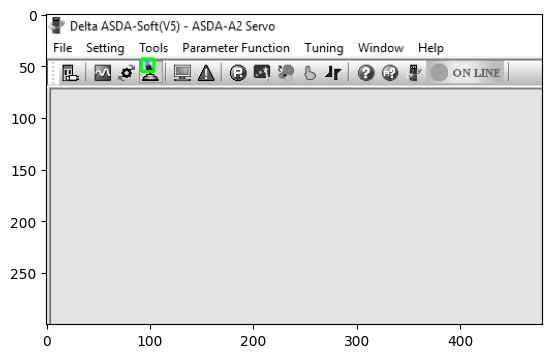

In [12]:
example=plt.imread(example_file)
plt.imshow(example)
example.shape

(303, 466, 3)

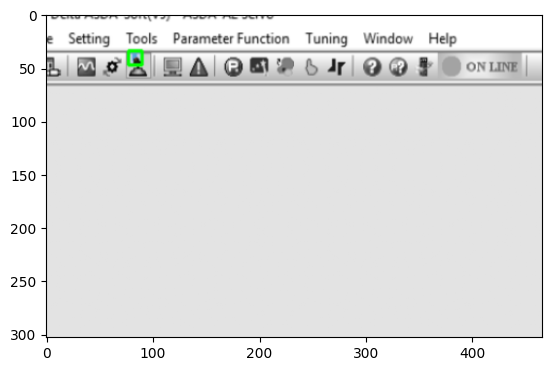

In [13]:
out=data_augment(np.expand_dims(example, axis=0))
plt.imshow(np.squeeze(out))
np.squeeze(out).shape

### Función para la creación de modelos

In [14]:
def create_model(model, type='transfer_learning', layers_num=None, dropout_rate=0.3):

    base_model=model(include_top=False)

    if type=='transfer_learning':
        base_model.trainable=False
    elif type=='fine_tuning':
        base_model.trainable=True
        for layer in base_model.layers[:-layers_num]:
            layer.trainable=False
    else:
        return None
    
    inputs=Input(shape=resolution+(3,))
    x=data_augment(inputs, training=True)
    x=Resizing(224, 224)(x)

    x=base_model(x)
    x=Dropout(dropout_rate)(x)
    x=GlobalAveragePooling2D()(x)
    outputs=Dense(num_classes, activation='softmax')(x)
    out_model=Model(inputs, outputs)

    return out_model

### Callbacks

In [15]:
#  Parar el modelo tras 5 épocas sin mejora en la 'validation loss'
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [16]:
# Reducir la tasa de aprendizaje tras 10 épocas para un ajuste más fino
def scheduler(epoch, lr):
    if epoch<=10:
        return lr
    else:
        return lr*np.exp(-0.9)

lr_scheduler=LearningRateScheduler(scheduler)

## EfficientNET

### Número de capas

In [17]:
print(f'{len(EfficientNetB0(include_top=False).layers)} layers')

238 layers


### Transfer Learning

In [18]:
EfficientNET_TL=create_model(EfficientNetB0, type='transfer_learning')
EfficientNET_TL.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 455, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                             

In [19]:
EfficientNET_TL.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
history_EfficientNET_TL=EfficientNET_TL.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler])

Epoch 1/100


2023-05-30 22:06:27.791283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [9213]
	 [[{{node Placeholder/_0}}]]
2023-05-30 22:06:27.791448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9213]
	 [[{{node Placeholder/_4}}]]
2023-05-30 22:06:31.283000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


  1/202 [..............................] - ETA: 14:50 - loss: 4.3593 - accuracy: 0.0000e+00

2023-05-30 22:06:32.052702: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-05-30 22:06:32.052724: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-05-30 22:06:32.052749: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-05-30 22:06:32.182872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


201/202 [============================>.] - ETA: 0s - loss: 4.2917 - accuracy: 0.0121

2023-05-30 22:06:39.619009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [9213]
	 [[{{node Placeholder/_0}}]]
2023-05-30 22:06:39.619204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9213]
	 [[{{node Placeholder/_4}}]]


202/202 [==============================] - 16s 56ms/step - loss: 4.2915 - accuracy: 0.0121 - val_loss: 4.2878 - val_accuracy: 0.0087 - lr: 1.0000e-04
Epoch 2/100
202/202 [==============================] - 11s 54ms/step - loss: 4.2867 - accuracy: 0.0111 - val_loss: 4.2878 - val_accuracy: 0.0109 - lr: 1.0000e-04
Epoch 3/100
202/202 [==============================] - 11s 54ms/step - loss: 4.2869 - accuracy: 0.0144 - val_loss: 4.2846 - val_accuracy: 0.0094 - lr: 1.0000e-04
Epoch 4/100
202/202 [==============================] - 11s 53ms/step - loss: 4.2886 - accuracy: 0.0130 - val_loss: 4.2872 - val_accuracy: 0.0116 - lr: 1.0000e-04
Epoch 5/100
202/202 [==============================] - 11s 54ms/step - loss: 4.2870 - accuracy: 0.0122 - val_loss: 4.2861 - val_accuracy: 0.0102 - lr: 1.0000e-04
Epoch 6/100
202/202 [==============================] - 11s 55ms/step - loss: 4.2866 - accuracy: 0.0128 - val_loss: 4.2879 - val_accuracy: 0.0102 - lr: 1.0000e-04
Epoch 7/100
202/202 [===================

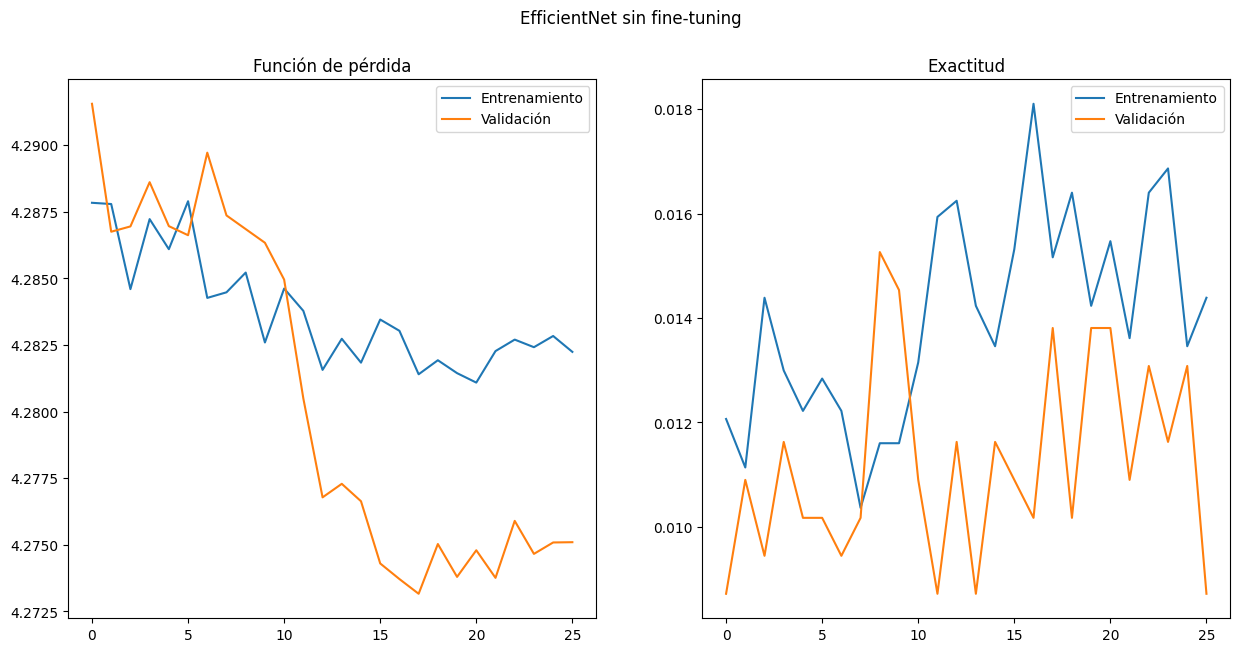

In [20]:
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(history_EfficientNET_TL.history['val_loss'], label='Entrenamiento')
ax1.plot(history_EfficientNET_TL.history['loss'], label='Validación')
ax1.legend()
ax1.set_title('Función de pérdida')
ax2.plot(history_EfficientNET_TL.history['accuracy'], label='Entrenamiento')
ax2.plot(history_EfficientNET_TL.history['val_accuracy'], label='Validación')
ax2.legend()
ax2.set_title('Exactitud')
fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('EfficientNet sin fine-tuning');

### Fine-tuning

In [63]:
EfficientNET_FT=create_model(EfficientNetB0, type='fine_tuning', layers_num=150)
EfficientNET_FT.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 256, 455, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 resizing_10 (Resizing)      (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 dropout_10 (Dropout)        (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d_10  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [64]:
EfficientNET_FT.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_EfficientNET_FT=EfficientNET_FT.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler])

Epoch 1/100


2023-05-30 21:43:33.026412: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


202/202 [==============================] - 17s 68ms/step - loss: 2.3014 - accuracy: 0.3880 - val_loss: 5.3031 - val_accuracy: 0.0327 - lr: 0.0010
Epoch 2/100
202/202 [==============================] - 13s 64ms/step - loss: 1.3823 - accuracy: 0.5919 - val_loss: 5.3047 - val_accuracy: 0.0661 - lr: 0.0010
Epoch 3/100
202/202 [==============================] - 13s 64ms/step - loss: 1.0345 - accuracy: 0.6739 - val_loss: 3.1617 - val_accuracy: 0.2318 - lr: 0.0010
Epoch 4/100
202/202 [==============================] - 13s 64ms/step - loss: 0.8729 - accuracy: 0.7226 - val_loss: 2.1352 - val_accuracy: 0.3946 - lr: 0.0010
Epoch 5/100
202/202 [==============================] - 13s 64ms/step - loss: 0.7648 - accuracy: 0.7593 - val_loss: 1.4466 - val_accuracy: 0.5967 - lr: 0.0010
Epoch 6/100
202/202 [==============================] - 13s 64ms/step - loss: 0.6253 - accuracy: 0.7949 - val_loss: 1.5624 - val_accuracy: 0.5516 - lr: 0.0010
Epoch 7/100
202/202 [==============================] - 13s 64ms/

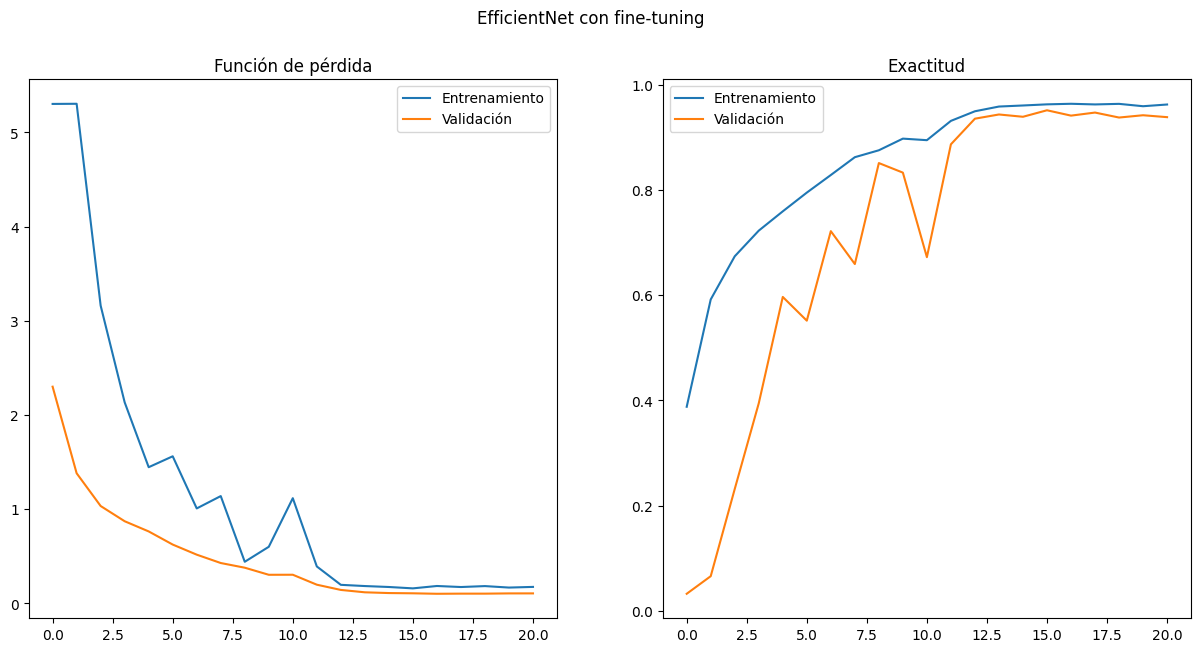

In [65]:
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(history_EfficientNET_FT.history['val_loss'], label='Entrenamiento')
ax1.plot(history_EfficientNET_FT.history['loss'], label='Validación')
ax1.legend()
ax1.set_title('Función de pérdida')
ax2.plot(history_EfficientNET_FT.history['accuracy'], label='Entrenamiento')
ax2.plot(history_EfficientNET_FT.history['val_accuracy'], label='Validación')
ax2.legend()
ax2.set_title('Exactitud')
fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('EfficientNet con fine-tuning');

## ResNET

### Número de capas

In [38]:
print(f'{len(ResNet50V2(include_top=False).layers)} layers')

190 layers


### Transfer Learning

In [39]:
ResNET_TL=create_model(ResNet50V2, type='transfer_learning')
ResNET_TL.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 455, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 resizing_3 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [40]:
ResNET_TL.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
history_ResNET_TL=ResNET_TL.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler])

Epoch 1/100
202/202 [==============================] - 13s 59ms/step - loss: 3.8774 - accuracy: 0.1337 - val_loss: 3.2384 - val_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 2/100
202/202 [==============================] - 11s 56ms/step - loss: 2.8758 - accuracy: 0.3775 - val_loss: 2.5471 - val_accuracy: 0.4702 - lr: 1.0000e-04
Epoch 3/100
202/202 [==============================] - 12s 57ms/step - loss: 2.3289 - accuracy: 0.4941 - val_loss: 2.1509 - val_accuracy: 0.5422 - lr: 1.0000e-04
Epoch 4/100
202/202 [==============================] - 12s 57ms/step - loss: 2.0048 - accuracy: 0.5616 - val_loss: 1.9135 - val_accuracy: 0.5727 - lr: 1.0000e-04
Epoch 5/100
202/202 [==============================] - 12s 57ms/step - loss: 1.7930 - accuracy: 0.5962 - val_loss: 1.7311 - val_accuracy: 0.6221 - lr: 1.0000e-04
Epoch 6/100
202/202 [==============================] - 12s 57ms/step - loss: 1.6327 - accuracy: 0.6309 - val_loss: 1.6165 - val_accuracy: 0.6461 - lr: 1.0000e-04
Epoch 7/100
202/202 [=======

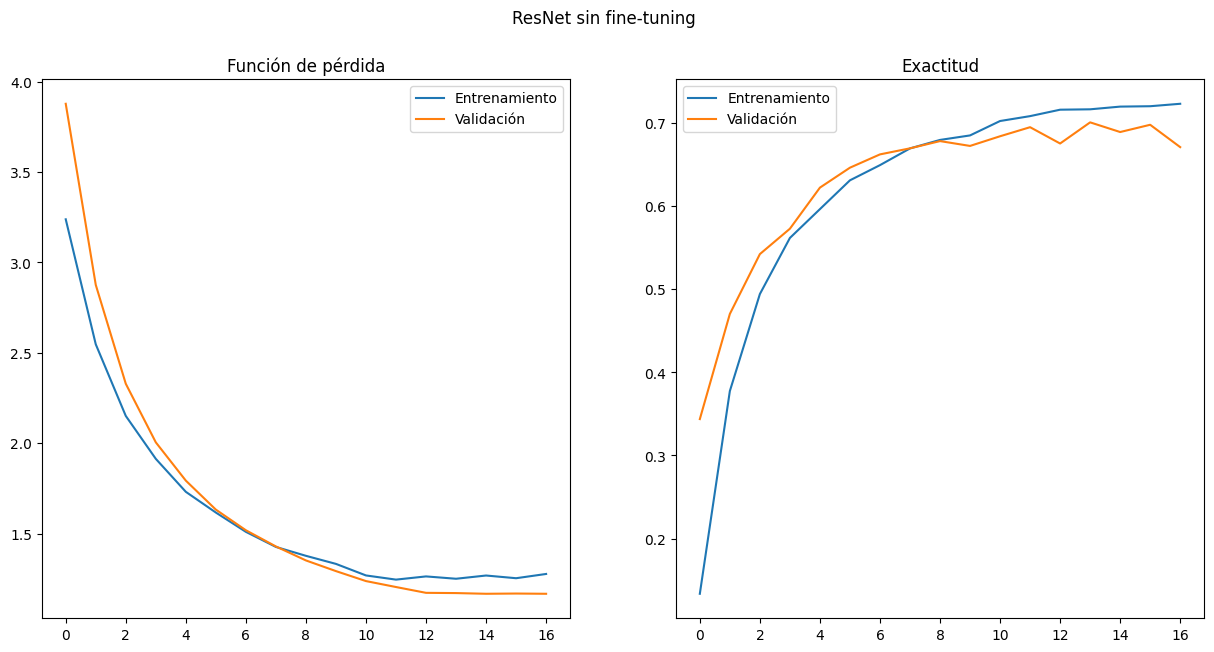

In [41]:
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(history_ResNET_TL.history['val_loss'], label='Entrenamiento')
ax1.plot(history_ResNET_TL.history['loss'], label='Validación')
ax1.legend()
ax1.set_title('Función de pérdida')
ax2.plot(history_ResNET_TL.history['accuracy'], label='Entrenamiento')
ax2.plot(history_ResNET_TL.history['val_accuracy'], label='Validación')
ax2.legend()
ax2.set_title('Exactitud')
fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('ResNet sin fine-tuning');

### Fine-tuning

In [42]:
ResNET_FT=create_model(ResNet50V2, type='fine_tuning', layers_num=80)
ResNET_FT.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 455, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 resizing_4 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [43]:
ResNET_FT.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
history_ResNET_FT=ResNET_FT.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler])

Epoch 1/100


2023-05-30 21:17:06.070576: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


202/202 [==============================] - 17s 75ms/step - loss: 1.3369 - accuracy: 0.6705 - val_loss: 0.5372 - val_accuracy: 0.8350 - lr: 1.0000e-04
Epoch 2/100
202/202 [==============================] - 15s 72ms/step - loss: 0.3676 - accuracy: 0.8832 - val_loss: 0.3411 - val_accuracy: 0.8975 - lr: 1.0000e-04
Epoch 3/100
202/202 [==============================] - 15s 72ms/step - loss: 0.2257 - accuracy: 0.9265 - val_loss: 0.2332 - val_accuracy: 0.9368 - lr: 1.0000e-04
Epoch 4/100
202/202 [==============================] - 15s 72ms/step - loss: 0.1720 - accuracy: 0.9448 - val_loss: 0.2106 - val_accuracy: 0.9404 - lr: 1.0000e-04
Epoch 5/100
202/202 [==============================] - 15s 72ms/step - loss: 0.1436 - accuracy: 0.9522 - val_loss: 0.1799 - val_accuracy: 0.9360 - lr: 1.0000e-04
Epoch 6/100
202/202 [==============================] - 15s 73ms/step - loss: 0.1354 - accuracy: 0.9567 - val_loss: 0.2130 - val_accuracy: 0.9339 - lr: 1.0000e-04
Epoch 7/100
202/202 [===================

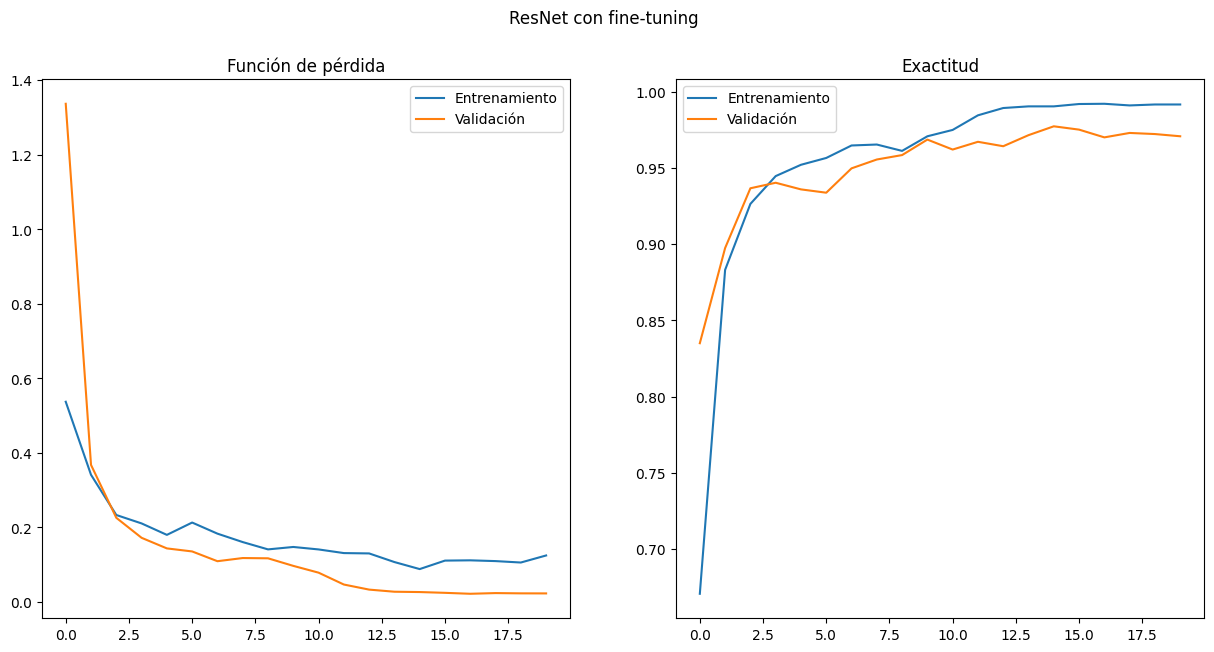

In [44]:
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(history_ResNET_FT.history['val_loss'], label='Entrenamiento')
ax1.plot(history_ResNET_FT.history['loss'], label='Validación')
ax1.legend()
ax1.set_title('Función de pérdida')
ax2.plot(history_ResNET_FT.history['accuracy'], label='Entrenamiento')
ax2.plot(history_ResNET_FT.history['val_accuracy'], label='Validación')
ax2.legend()
ax2.set_title('Exactitud')
fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('ResNet con fine-tuning');

## Inception

### Número de capas

In [45]:
print(f'{len(InceptionV3(include_top=False).layers)} layers')

311 layers


### Transfer Learning

In [46]:
Inception_TL=create_model(InceptionV3, type='transfer_learning')
Inception_TL.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 455, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 resizing_5 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 dropout_5 (Dropout)         (None, 5, 5, 2048)        0         
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [47]:
Inception_TL.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
history_Inception_TL=Inception_TL.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler])

Epoch 1/100
202/202 [==============================] - 12s 49ms/step - loss: 3.6337 - accuracy: 0.1946 - val_loss: 2.9857 - val_accuracy: 0.4012 - lr: 1.0000e-04
Epoch 2/100
202/202 [==============================] - 9s 46ms/step - loss: 2.6071 - accuracy: 0.4542 - val_loss: 2.3347 - val_accuracy: 0.5073 - lr: 1.0000e-04
Epoch 3/100
202/202 [==============================] - 9s 46ms/step - loss: 2.0895 - accuracy: 0.5540 - val_loss: 1.9891 - val_accuracy: 0.5538 - lr: 1.0000e-04
Epoch 4/100
202/202 [==============================] - 9s 46ms/step - loss: 1.7984 - accuracy: 0.6033 - val_loss: 1.7342 - val_accuracy: 0.6206 - lr: 1.0000e-04
Epoch 5/100
202/202 [==============================] - 9s 46ms/step - loss: 1.6105 - accuracy: 0.6324 - val_loss: 1.5896 - val_accuracy: 0.6374 - lr: 1.0000e-04
Epoch 6/100
202/202 [==============================] - 9s 46ms/step - loss: 1.4610 - accuracy: 0.6562 - val_loss: 1.4518 - val_accuracy: 0.6570 - lr: 1.0000e-04
Epoch 7/100
202/202 [============

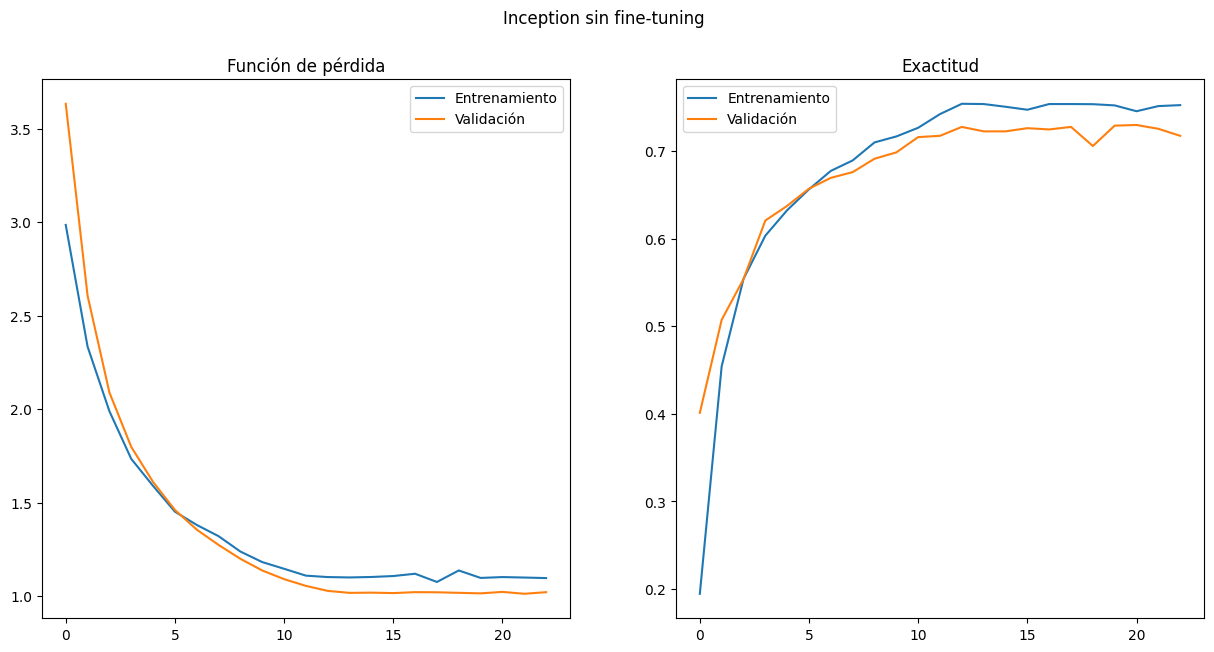

In [48]:
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(history_Inception_TL.history['val_loss'], label='Entrenamiento')
ax1.plot(history_Inception_TL.history['loss'], label='Validación')
ax1.legend()
ax1.set_title('Función de pérdida')
ax2.plot(history_Inception_TL.history['accuracy'], label='Entrenamiento')
ax2.plot(history_Inception_TL.history['val_accuracy'], label='Validación')
ax2.legend()
ax2.set_title('Exactitud')
fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('Inception sin fine-tuning');

### Fine tuning

In [49]:
Inception_FT=create_model(InceptionV3, type='fine_tuning', layers_num=100)
Inception_FT.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 256, 455, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 resizing_6 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 dropout_6 (Dropout)         (None, 5, 5, 2048)        0         
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [50]:
Inception_FT.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
history_Inception_FT=Inception_FT.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler])

Epoch 1/100


2023-05-30 21:29:36.716671: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


202/202 [==============================] - 13s 55ms/step - loss: 1.4234 - accuracy: 0.6481 - val_loss: 0.5529 - val_accuracy: 0.8140 - lr: 1.0000e-04
Epoch 2/100
202/202 [==============================] - 11s 52ms/step - loss: 0.4521 - accuracy: 0.8504 - val_loss: 0.3598 - val_accuracy: 0.8779 - lr: 1.0000e-04
Epoch 3/100
202/202 [==============================] - 11s 52ms/step - loss: 0.2862 - accuracy: 0.9015 - val_loss: 0.3123 - val_accuracy: 0.8946 - lr: 1.0000e-04
Epoch 4/100
202/202 [==============================] - 11s 53ms/step - loss: 0.2293 - accuracy: 0.9230 - val_loss: 0.2512 - val_accuracy: 0.9157 - lr: 1.0000e-04
Epoch 5/100
202/202 [==============================] - 11s 53ms/step - loss: 0.1826 - accuracy: 0.9358 - val_loss: 0.2231 - val_accuracy: 0.9259 - lr: 1.0000e-04
Epoch 6/100
202/202 [==============================] - 11s 52ms/step - loss: 0.1615 - accuracy: 0.9457 - val_loss: 0.1801 - val_accuracy: 0.9426 - lr: 1.0000e-04
Epoch 7/100
202/202 [===================

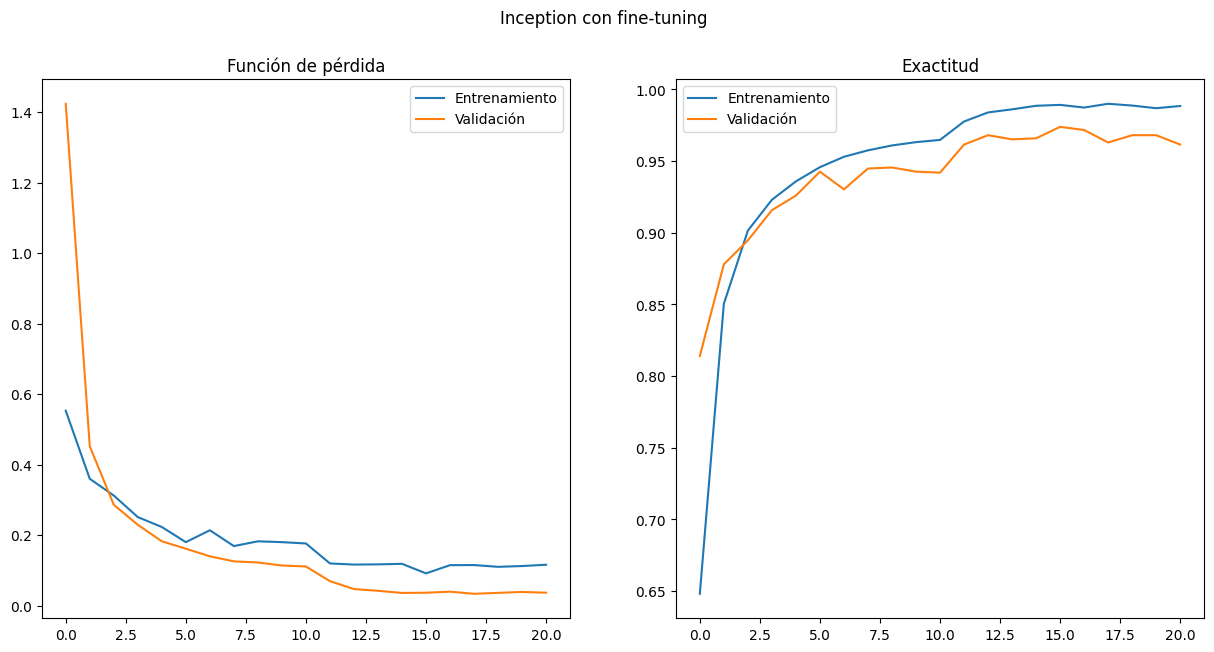

In [51]:
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(history_Inception_FT.history['val_loss'], label='Entrenamiento')
ax1.plot(history_Inception_FT.history['loss'], label='Validación')
ax1.legend()
ax1.set_title('Función de pérdida')
ax2.plot(history_Inception_FT.history['accuracy'], label='Entrenamiento')
ax2.plot(history_Inception_FT.history['val_accuracy'], label='Validación')
ax2.legend()
ax2.set_title('Exactitud')
fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('Inception con fine-tuning');

## MobileNET

### Número de capas

In [52]:
print(f'{len(MobileNet(include_top=False).layers)} layers')

86 layers


### Transfer learning

In [53]:
MobileNet_TL=create_model(model=MobileNet, type='transfer_learning')
MobileNet_TL.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 256, 455, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 resizing_7 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d_7   (None, 1024)             0         
 (GlobalAveragePooling2D)                                  

In [54]:
MobileNet_TL.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
history_MobileNet_TL=MobileNet_TL.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler])

Epoch 1/100
202/202 [==============================] - 9s 41ms/step - loss: 3.8145 - accuracy: 0.1214 - val_loss: 3.1495 - val_accuracy: 0.2936 - lr: 1.0000e-04
Epoch 2/100
202/202 [==============================] - 8s 40ms/step - loss: 2.7620 - accuracy: 0.3946 - val_loss: 2.4471 - val_accuracy: 0.4818 - lr: 1.0000e-04
Epoch 3/100
202/202 [==============================] - 8s 39ms/step - loss: 2.2164 - accuracy: 0.5178 - val_loss: 2.0182 - val_accuracy: 0.5581 - lr: 1.0000e-04
Epoch 4/100
202/202 [==============================] - 8s 40ms/step - loss: 1.8853 - accuracy: 0.5767 - val_loss: 1.8011 - val_accuracy: 0.5981 - lr: 1.0000e-04
Epoch 5/100
202/202 [==============================] - 8s 41ms/step - loss: 1.6648 - accuracy: 0.6081 - val_loss: 1.6363 - val_accuracy: 0.6170 - lr: 1.0000e-04
Epoch 6/100
202/202 [==============================] - 8s 41ms/step - loss: 1.5174 - accuracy: 0.6341 - val_loss: 1.5017 - val_accuracy: 0.6235 - lr: 1.0000e-04
Epoch 7/100
202/202 [=============

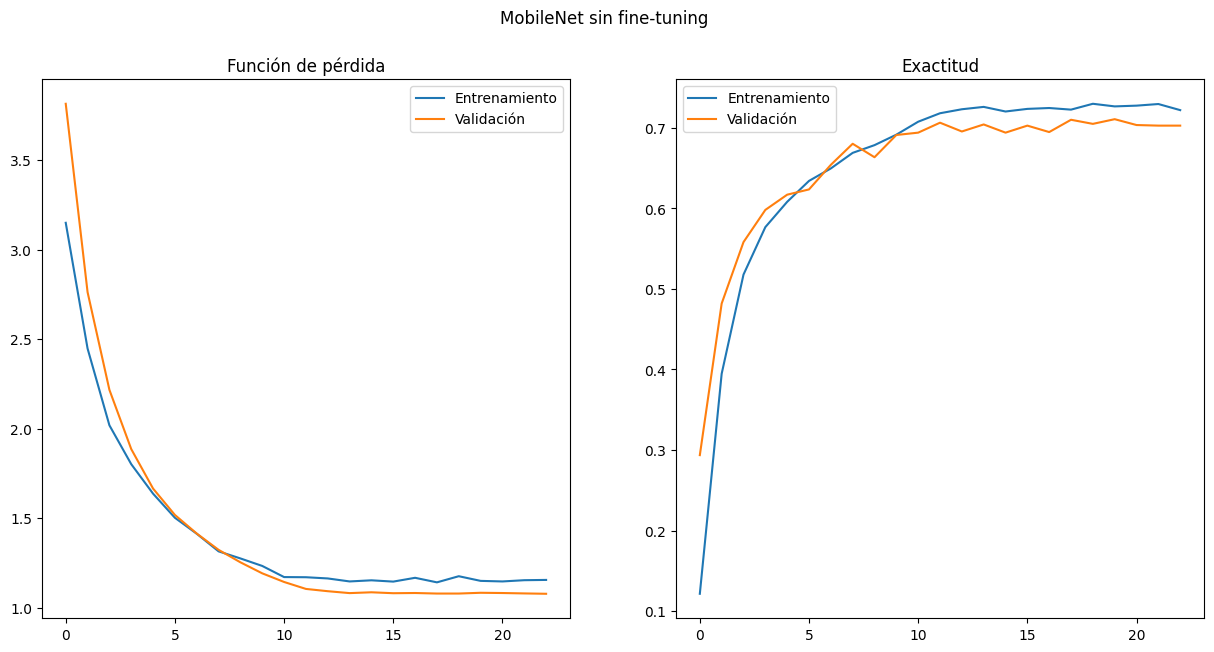

In [55]:
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(history_MobileNet_TL.history['val_loss'], label='Entrenamiento')
ax1.plot(history_MobileNet_TL.history['loss'], label='Validación')
ax1.legend()
ax1.set_title('Función de pérdida')
ax2.plot(history_MobileNet_TL.history['accuracy'], label='Entrenamiento')
ax2.plot(history_MobileNet_TL.history['val_accuracy'], label='Validación')
ax2.legend()
ax2.set_title('Exactitud')
fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('MobileNet sin fine-tuning');

### Fine tuning

In [57]:
MobileNet_FT=create_model(model=MobileNet, type='fine_tuning', layers_num=50)
MobileNet_FT.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 256, 455, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 resizing_9 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d_9   (None, 1024)             0         
 (GlobalAveragePooling2D)                                  

In [58]:
MobileNet_FT.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
history_MobileNet_FT=MobileNet_FT.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler])

Epoch 1/100


2023-05-30 21:38:20.692912: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


202/202 [==============================] - 11s 47ms/step - loss: 1.6604 - accuracy: 0.5792 - val_loss: 1.0678 - val_accuracy: 0.7049 - lr: 1.0000e-04
Epoch 2/100
202/202 [==============================] - 9s 46ms/step - loss: 0.6165 - accuracy: 0.8238 - val_loss: 0.5471 - val_accuracy: 0.8358 - lr: 1.0000e-04
Epoch 3/100
202/202 [==============================] - 9s 45ms/step - loss: 0.3657 - accuracy: 0.8937 - val_loss: 0.3713 - val_accuracy: 0.8844 - lr: 1.0000e-04
Epoch 4/100
202/202 [==============================] - 9s 45ms/step - loss: 0.2593 - accuracy: 0.9253 - val_loss: 0.2588 - val_accuracy: 0.9288 - lr: 1.0000e-04
Epoch 5/100
202/202 [==============================] - 9s 46ms/step - loss: 0.1901 - accuracy: 0.9466 - val_loss: 0.2179 - val_accuracy: 0.9404 - lr: 1.0000e-04
Epoch 6/100
202/202 [==============================] - 9s 45ms/step - loss: 0.1496 - accuracy: 0.9581 - val_loss: 0.1845 - val_accuracy: 0.9484 - lr: 1.0000e-04
Epoch 7/100
202/202 [========================

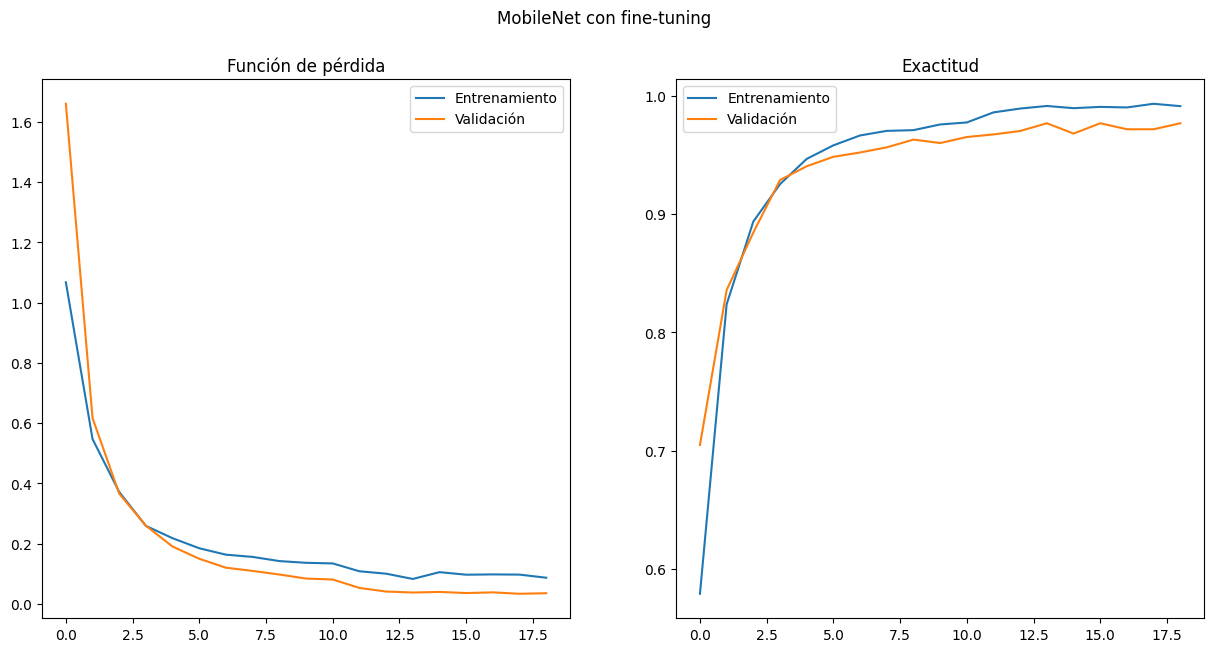

In [59]:
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(history_MobileNet_FT.history['val_loss'], label='Entrenamiento')
ax1.plot(history_MobileNet_FT.history['loss'], label='Validación')
ax1.legend()
ax1.set_title('Función de pérdida')
ax2.plot(history_MobileNet_FT.history['accuracy'], label='Entrenamiento')
ax2.plot(history_MobileNet_FT.history['val_accuracy'], label='Validación')
ax2.legend()
ax2.set_title('Exactitud')
fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('MobileNet con fine-tuning');

# Evaluacion de modelos

In [60]:
def get_final_model(model):

    final_model=Sequential()

    final_model.add(Input(shape=(224,224,3)))
    for layer in model.layers[3:]:
        final_model.add(layer)

    final_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=0.001))

    return final_model

In [69]:
n_data=0
for x,y in test:
    n_data+=len(x)
print(f'{n_data} datos en el set de prueba')

1373 datos en el set de prueba


In [74]:
start=time.time()
accuracy=get_final_model(EfficientNET_FT).evaluate(test, verbose=0)[1]
end=time.time()
print(f'Tiempo de ejecución: {end-start:.4f}s, accuracy: {accuracy:.4f}')
print(f'Tiempo de ejecución por archivo: {(end-start)/n_data*1000:.4f}ms')

Tiempo de ejecución: 4.4234s, accuracy: 0.9541
Tiempo de ejecución por archivo: 3.2217ms


In [73]:
start=time.time()
accuracy=get_final_model(ResNET_FT).evaluate(test, verbose=0)[1]
end=time.time()
print(f'Tiempo de ejecución: {end-start:.4f}s, accuracy: {accuracy:.4f}')
print(f'Tiempo de ejecución por archivo: {(end-start)/n_data*1000:.4f}ms')

Tiempo de ejecución: 4.1395s, accuracy: 0.9731
Tiempo de ejecución por archivo: 3.0149ms


In [75]:
start=time.time()
accuracy=get_final_model(Inception_FT).evaluate(test, verbose=0)[1]
end=time.time()
print(f'Tiempo de ejecución: {end-start:.4f}s, accuracy: {accuracy:.4f}')
print(f'Tiempo de ejecución por archivo: {(end-start)/n_data*1000:.4f}ms')

Tiempo de ejecución: 4.1134s, accuracy: 0.9636
Tiempo de ejecución por archivo: 2.9959ms


In [76]:
start=time.time()
accuracy=get_final_model(MobileNet_FT).evaluate(test, verbose=0)[1]
end=time.time()
print(f'Tiempo de ejecución: {end-start:.4f}s, accuracy: {accuracy:.4f}')
print(f'Tiempo de ejecución por archivo: {(end-start)/n_data*1000:.4f}ms')

Tiempo de ejecución: 3.1438s, accuracy: 0.9709
Tiempo de ejecución por archivo: 2.2897ms
